In [1]:
import numpy as np


In [2]:
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

Using TensorFlow backend.


In [3]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers

In [4]:
#Helper function to create Sequential part of the Architecture
def FCN_16_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))
    
    
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
    
    
    model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc_6"))
    
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
    
    
    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
    
    
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    print(Conv_size)
    
    model.add(Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    # O = ((I-K+2*P)/Stride)+1 
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding
    
    # I = (O-1)*Stride + K 
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512
    
    print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)
    
    print(Extra)
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    return model

output = FCN_16_helper(512)
print(len(output.layers))
print(output.layers[14])
print output.summary()
    
    

16
34
2
24
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 256, 256, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 256, 256, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 128, 128, 128)     0         

In [5]:
def FCN_16(image_size) :
    fcn_16 = FCN_16_helper(512)
    
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_16.layers[-1].output_shape[2] 
    
    skip_con = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con(fcn_16.layers[14].output),fcn_16.layers[-1].output])
    
    
    Up = Deconvolution2D(21,kernel_size=(32,32),strides = (16,16),padding = "valid",activation = None,name = "upsample_new")
    
    #528 if image size is 512*512
    Deconv_size = (Conv_size-1)*16+32
    
    #16 if image size is 512*512
    extra_margin = (Deconv_size - Conv_size*16)
    
    #Cropping to get the original size of the image
    crop = Cropping2D(cropping = ((0,extra_margin),(0,extra_margin)))
    return Model(fcn_16.input, crop(Up(Summed)))

output = FCN_16(512)

print(output.summary())

16
34
2
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_2_input (InputLayer)     (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
permute_2 (Permute)              (None, 512, 512, 3)   0           permute_2_input[0][0]            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 512, 512, 64)  1792        permute_2[0][0]                  
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 512, 512, 64)  36928       conv1_1[0][0]                    
___________________________________________________________________________________

In [6]:
image_size = 512
fcn16_model = FCN_16(512)
fcn16_model.summary()

16
34
2
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_3_input (InputLayer)     (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
permute_3 (Permute)              (None, 512, 512, 3)   0           permute_3_input[0][0]            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 512, 512, 64)  1792        permute_3[0][0]                  
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 512, 512, 64)  36928       conv1_1[0][0]                    
___________________________________________________________________________________

In [7]:
from keras.utils import plot_model

In [8]:
plot_model(fcn16_model,"FCN-16.png")

In [9]:
plot_model(fcn16_model,"FCN-16_withshape.png",show_shapes=True)

In [10]:
from scipy.io import loadmat

In [11]:
data = loadmat('pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
layers = data['layers']
params = data['params']
description = data['meta'][0,0].classes[0,0].description

IOError: [Errno 2] No such file or directory: 'pascal-fcn16s-dag.mat'

In [10]:
print(data.keys())

['layers', 'vars', '__header__', '__globals__', 'meta', 'params', '__version__']


In [11]:
print(type(layers))

<type 'numpy.ndarray'>


In [12]:
print(layers.shape)

(1, 42)


In [13]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [14]:
for i in range(0, params.shape[1]-1, 2):
    print(i,
          str(params[0,i].name[0]), params[0,i].value.shape,
          str(params[0,i+1].name[0]), params[0,i+1].value.shape)

(0, 'conv1_1_filter', (3, 3, 3, 64), 'conv1_1_bias', (64, 1))
(2, 'conv1_2_filter', (3, 3, 64, 64), 'conv1_2_bias', (64, 1))
(4, 'conv2_1_filter', (3, 3, 64, 128), 'conv2_1_bias', (128, 1))
(6, 'conv2_2_filter', (3, 3, 128, 128), 'conv2_2_bias', (128, 1))
(8, 'conv3_1_filter', (3, 3, 128, 256), 'conv3_1_bias', (256, 1))
(10, 'conv3_2_filter', (3, 3, 256, 256), 'conv3_2_bias', (256, 1))
(12, 'conv3_3_filter', (3, 3, 256, 256), 'conv3_3_bias', (256, 1))
(14, 'conv4_1_filter', (3, 3, 256, 512), 'conv4_1_bias', (512, 1))
(16, 'conv4_2_filter', (3, 3, 512, 512), 'conv4_2_bias', (512, 1))
(18, 'conv4_3_filter', (3, 3, 512, 512), 'conv4_3_bias', (512, 1))
(20, 'conv5_1_filter', (3, 3, 512, 512), 'conv5_1_bias', (512, 1))
(22, 'conv5_2_filter', (3, 3, 512, 512), 'conv5_2_bias', (512, 1))
(24, 'conv5_3_filter', (3, 3, 512, 512), 'conv5_3_bias', (512, 1))
(26, 'fc6_filter', (7, 7, 512, 4096), 'fc6_bias', (4096, 1))
(28, 'fc7_filter', (1, 1, 4096, 4096), 'fc7_bias', (4096, 1))
(30, 'score_fr_filt

In [15]:
for i in range(layers.shape[1]):
    print(i,
          str(layers[0,i].name[0]), str(layers[0,i].type[0]),
          [str(n[0]) for n in layers[0,i].inputs[0,:]],
          [str(n[0]) for n in layers[0,i].outputs[0,:]])

(0, 'conv1_1', 'dagnn.Conv', ['data'], ['conv1_1'])
(1, 'relu1_1', 'dagnn.ReLU', ['conv1_1'], ['conv1_1x'])
(2, 'conv1_2', 'dagnn.Conv', ['conv1_1x'], ['conv1_2'])
(3, 'relu1_2', 'dagnn.ReLU', ['conv1_2'], ['conv1_2x'])
(4, 'pool1', 'dagnn.Pooling', ['conv1_2x'], ['pool1'])
(5, 'conv2_1', 'dagnn.Conv', ['pool1'], ['conv2_1'])
(6, 'relu2_1', 'dagnn.ReLU', ['conv2_1'], ['conv2_1x'])
(7, 'conv2_2', 'dagnn.Conv', ['conv2_1x'], ['conv2_2'])
(8, 'relu2_2', 'dagnn.ReLU', ['conv2_2'], ['conv2_2x'])
(9, 'pool2', 'dagnn.Pooling', ['conv2_2x'], ['pool2'])
(10, 'conv3_1', 'dagnn.Conv', ['pool2'], ['conv3_1'])
(11, 'relu3_1', 'dagnn.ReLU', ['conv3_1'], ['conv3_1x'])
(12, 'conv3_2', 'dagnn.Conv', ['conv3_1x'], ['conv3_2'])
(13, 'relu3_2', 'dagnn.ReLU', ['conv3_2'], ['conv3_2x'])
(14, 'conv3_3', 'dagnn.Conv', ['conv3_2x'], ['conv3_3'])
(15, 'relu3_3', 'dagnn.ReLU', ['conv3_3'], ['conv3_3x'])
(16, 'pool3', 'dagnn.Pooling', ['conv3_3x'], ['pool3'])
(17, 'conv4_1', 'dagnn.Conv', ['pool3'], ['conv4_1'])


In [16]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, params.shape[1]-1, 2):
        matname = '_'.join(params[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = params[0,i].value
            l_bias = params[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [17]:
copy_mat_to_keras(fcn16_model)

('found : ', ('conv1_1', 2))
((3, 3, 3, 64), (3, 3, 3, 64))
('found : ', ('conv1_2', 3))
((3, 3, 64, 64), (3, 3, 64, 64))
('found : ', ('conv2_1', 5))
((3, 3, 64, 128), (3, 3, 64, 128))
('found : ', ('conv2_2', 6))
((3, 3, 128, 128), (3, 3, 128, 128))
('found : ', ('conv3_1', 8))
((3, 3, 128, 256), (3, 3, 128, 256))
('found : ', ('conv3_2', 9))
((3, 3, 256, 256), (3, 3, 256, 256))
('found : ', ('conv3_3', 10))
((3, 3, 256, 256), (3, 3, 256, 256))
('found : ', ('conv4_1', 12))
((3, 3, 256, 512), (3, 3, 256, 512))
('found : ', ('conv4_2', 13))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv4_3', 14))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_1', 16))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_2', 17))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_3', 18))
((3, 3, 512, 512), (3, 3, 512, 512))
('not found : ', 'fc6')
('found : ', ('fc7', 21))
((1, 1, 4096, 4096), (1, 1, 4096, 4096))
('found : ', ('score_fr', 22))
((1, 1, 4096, 21), (1, 1,

In [12]:
fcn16_model.load_weights('weights.h5')

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [15]:
im = Image.open('TestImages/2007_000032.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))

In [16]:
from skimage.io import imread, imsave

In [24]:
imsave("orginal_image1.png",im)


(512, 512, 3)


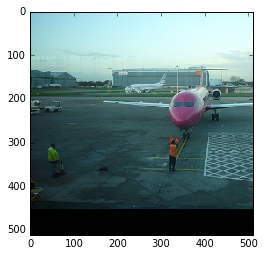

In [17]:
plt.imshow(np.asarray(im))
print(np.asarray(im).shape)

In [18]:
import copy
import math

In [19]:
def prediction(kmodel, crpimg, transform=False):
	# INFO : crpimg should be a cropped image of the right dimension


	imarr = np.array(crpimg).astype(np.float32)

	if transform:
		imarr[:, :, 0] -= 129.1863
		imarr[:, :, 1] -= 104.7624
		imarr[:, :, 2] -= 93.5940
		
		aux = copy.copy(imarr)
		imarr[:, :, 0] = aux[:, :, 2]
		imarr[:, :, 2] = aux[:, :, 0]

	# imarr[:,:,0] -= 129.1863
	# imarr[:,:,1] -= 104.7624
	# imarr[:,:,2] -= 93.5940

	# imarr = imarr.transpose((2, 0, 1))
	imarr = np.expand_dims(imarr, axis=0)

	return kmodel.predict(imarr)

In [20]:
crpim = im 
preds = prediction(fcn16_model, crpim, transform=False) 

In [29]:
im = Image.open('TestImages/2007_000032_ground_truth.png') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))

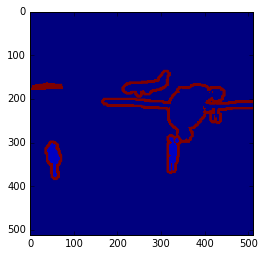

In [30]:
plt.imshow(np.asarray(im))

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


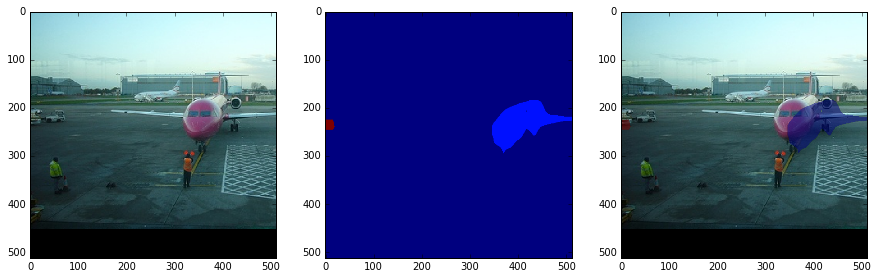

In [31]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [32]:
imclass.shape

(512, 512)

In [33]:
np.unique(imclass)

array([0, 1, 7])

In [34]:
from scipy.misc import imsave

In [35]:
imsave('annotation1.png',imclass)


In [36]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(1, 'aeroplane')
(7, 'car')


In [37]:
im1 = Image.open('TestImages/2007_000033.jpg')
im1 = im1.crop((0,0,319,319)) # WARNING : manual square cropping
im1 = im1.resize((image_size,image_size))

(512, 512, 3)


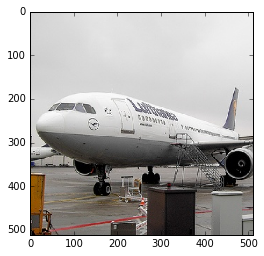

In [38]:
plt.imshow(np.asarray(im1))
imsave("Aeroplane.png",im1)
print(np.asarray(im1).shape)

In [40]:
preds = prediction(fcn16_model, im1, transform=False)

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


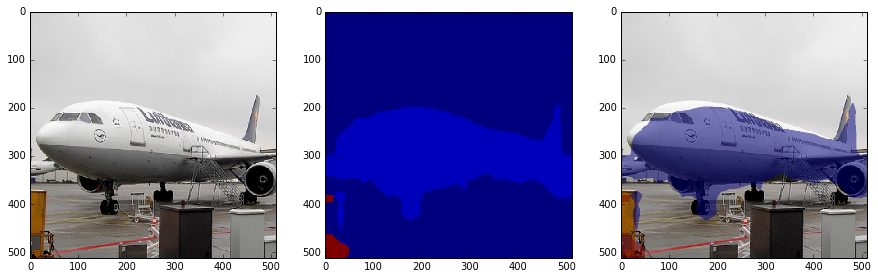

In [41]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
print(len(imclass))
imsave("Annotation2.png",imclass)
print(imclass.shape)
print(imclass.shape)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im1) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im1) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [40]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(1, 'aeroplane')
(19, 'train')


In [69]:
im1 = Image.open('TestImages/rgb.jpg')
im1 = im1.crop((0,0,319,319)) # manual square cropping
im1 = im1.resize((image_size,image_size))
imsave("original_image2.png",im1)

(512, 512, 3)


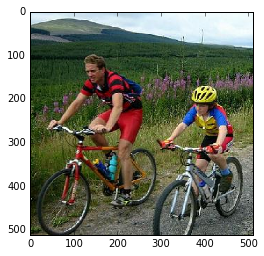

In [66]:
plt.imshow(np.asarray(im1))
print(np.asarray(im1).shape)

In [67]:
preds = prediction(fcn16_model, im1, transform=False)

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


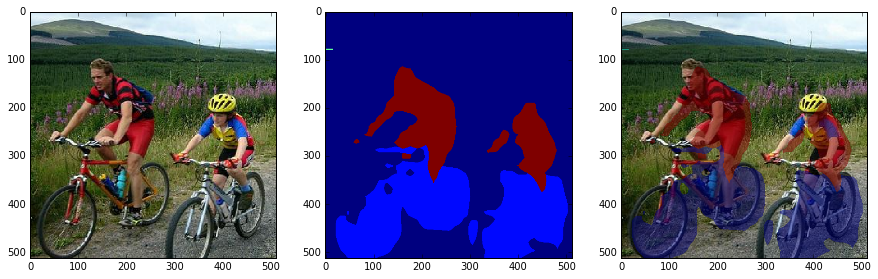

In [68]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)
imsave("annotation2.png",imclass)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im1) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im1) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [45]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(2, 'bicycle')
(7, 'car')
(15, 'person')


In [21]:
im1 = Image.open('TestImages/2012_003238.jpg')
im1 = im1.crop((100,0,319,319)) # manual square cropping
im1 = im1.resize((image_size,image_size))

(512, 512, 3)


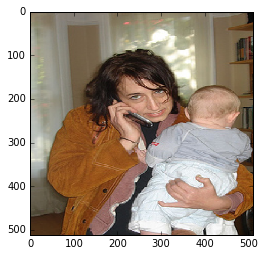

In [22]:
plt.imshow(np.asarray(im1))
print(np.asarray(im1).shape)

In [23]:
preds = prediction(fcn16_model, im1, transform=False)

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


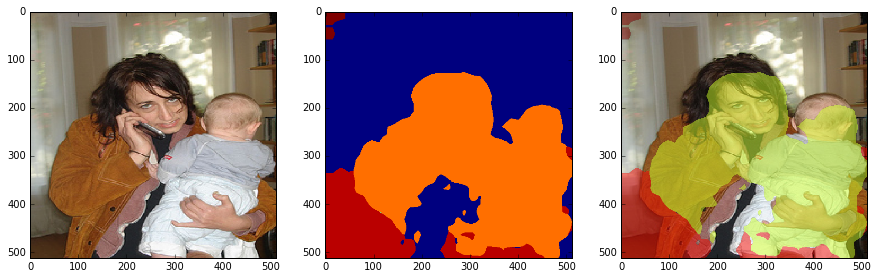

In [25]:
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
imsave("annotation4_fcn16.png",imclass)
print(len(imclass))
print(imclass.shape)
print(imclass.shape)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im1) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im1) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [73]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(9, 'chair')
(15, 'person')
(18, 'sofa')
(19, 'train')
